<!-- docusaurus_head_meta::start
---
title: Introduction Notebook
---
docusaurus_head_meta::end -->

<img src="http://wandb.me/logo-im-png" width="400" alt="Weights & Biases" />
<!--- @wandbcode{intro-colab} -->

# Evaluating hallucination in RAG Pipelines with Weave Integration

This notebook demonstrates how to evaluate hallucination of language models in answers coming from a Retrieval-Augmented Generation (RAG) response. We will integrate this with Weave for tracking function inputs and outputs, creating objects out of prompts, and running evaluations with different datasets.

## Objectives:

* Implement a RAG pipeline that includes  hallucination detection mechanism using both built-in weave scorer and also an open source ML model trained specifically for hallucination detection.
* Integrate Weave to track all function calls, inputs, and outputs.
* Register three different evaluation datasets and showcase evaluation steps.

## Stack Used:

* OpenAI API for language models and embeddings.
* Weave and it's built-in hallucination scorer by Weights & Biases for tracking and evaluation.
* open source hallucination_evaluation_model from hugging face as secondary approach

Note:Ensure you have the necessary API keys set up in your environment.



## 🪄 Install `weave` library and login


Start by installing the library and logging in to your account.

In this example, we're using openai so you should [add an openai API key](https://platform.openai.com/docs/quickstart/step-2-setup-your-api-key).



In [ ]:
%%capture
!pip install weave \
weave[scorers] \
openai set-env-colab-kaggle-dotenv \
requests \
python-dotenv==1.0.1 \
PyPDF2 \
unstructured \
pdfminer.six \
transformers \
nltk \
torch \
llama-index

The pre-defined scorers that use LLMs support the OpenAI, Anthropic, Google GenerativeAI and MistralAI clients. They also use weave's InstructorLLMScorer class, so you'll need to install the instructor Python package to be able to use them. You can get all necessary dependencies with pip install "weave[scorers]"

In [ ]:
from set_env import set_env

# Set your OpenAI API key
# Put your OPENAI_API_KEY in the secrets panel to the left 🗝️
_ = set_env("OPENAI_API_KEY")
# os.environ["OPENAI_API_KEY"] = "sk-..." # alternatively, put your key here
PROJECT = "Hallucination_Check"

In [ ]:
import weave

weave.init(PROJECT)  # initialize tracking for a specific W&B project


## 📚 Import Necessary Libraries

We'll import all the required libraries for our project:


In [ ]:
import os
from typing import Any, Dict, List
import nltk
import requests
import torch
from llama_index.core import SimpleDirectoryReader, VectorStoreIndex
from llama_index.embeddings.openai import OpenAIEmbedding
from openai import OpenAI
import weave
from weave.scorers import HallucinationFreeScorer
nltk.download("punkt_tab")

Loading Hallucination detection model (HHEM-2.1):

HHEM-2.1-Open is an open-source model designed to detect hallucinations in large language models (LLMs). It is particularly effective in retrieval-augmented generation (RAG) workflows, where an LLM summarizes facts, and the goal is to assess the factual consistency of the summary.

While we are using HHEM-2.1-Open for this demonstration, there are also other models available that can suit different needs and contexts. Here are a couple of examples:

- [**PHI 3.5 Hallucination Judge**](https://huggingface.co/grounded-ai/phi3.5-hallucination-judge)
- [**XLM-RoBERTa-XL Hallucination Detector**](https://huggingface.co/bond005/xlm-roberta-xl-hallucination-detector)

These are just a few of the many available models—you can explore others on platforms like Hugging Face.

Additionally, you could opt for the LLM-as-Judge approach, where you prompt your preferred LLM to evaluate whether the response from a previous LLM aligns with the provided facts or context. This method gives you the flexibility to adapt the evaluation process according to your preferences and the available models.

In summary, HHEM-2.1-Open was chosen for this demonstration due to its efficiency: it requires less than 600MB of RAM (32-bit precision) and processes 2k-token inputs in approximately 1.5 seconds on a modern x86 CPU. However, you are encouraged to experiment with other models to find the best fit for your needs.


In [ ]:
%%capture
# Load the model with custom code
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "vectara/hallucination_evaluation_model", trust_remote_code=True
)
model.eval()  # Set the model to evaluation mode

## 🔑 Initialize OpenAI Client and Embedding Model

Create an OpenAI client instance for API calls and set up the embedding model.



In [ ]:
# Initialize OpenAI client
client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY"),
)

# Set up embedding model
embedding_model = OpenAIEmbedding(model="text-embedding-ada-002")

## 📥 Download and Load Documents

We'll download a PDF document from a URL and create an index using LlamaIndex. Please note that this can be your own vector database with your data indexed for your RAG Chatbot.




In [ ]:
# Download the PDF from a URL
pdf_url = "https://arxiv.org/pdf/2408.13296v1.pdf"  # Replace with your PDF URL
pdf_filename = "document.pdf"

response = requests.get(pdf_url)
with open(pdf_filename, "wb") as f:
    f.write(response.content)

# Load the documents from the PDF
documents = SimpleDirectoryReader(input_dir=".", required_exts=[".pdf"]).load_data()

# Create the index from the documents
index = VectorStoreIndex.from_documents(documents, embed_model=embedding_model)

## 🔎 Create Query Engine

Set up the query engine with a limit on the number of retrieved documents.



In [ ]:
# Create the query engine
query_engine = index.as_query_engine(similarity_top_k=1)

## 🛠️ Define Weave-Tracked Functions

We'll define our functions for the pipeline and use `@weave.op()` to decorate them, enabling Weave to track their inputs and outputs.

### 1. Retrieve Context

This function retrieves relevant context for the question using the LlamaIndex query engine.



In [ ]:
@weave.op()
def retrieve_context(question: str) -> str:
    """Retrieves relevant context for the question using LlamaIndex query engine."""
    response = query_engine.query(question)
    if response.source_nodes:
        # Concatenate all chunks with chunk numbers and separators
        combined_text = ""
        for idx, node in enumerate(response.source_nodes):
            chunk_header = f"Chunk {idx + 1}:\n"
            chunk_text = node.node.text
            separator = "\n" + "-" * 80 + "\n"
            combined_text += chunk_header + chunk_text + separator
        return combined_text
    else:
        return "No context or chunks retrieved."

### 2. Generate Answer

This function generates an answer to the question based on the provided context using OpenAI's GPT model.



In [ ]:
@weave.op()
def generate_answer(question: str, context: str, model_name: str) -> str:
    """Generates an answer to the question based on the provided context using OpenAI's GPT model."""
    messages = [
        {
            "role": "system",
            "content": "You are a helpful assistant that answers questions based on the provided context.",
        },
        {"role": "user", "content": f"Context:\n{context}\n\nQuestion:\n{question}"},
    ]
    response = client.chat.completions.create(
        model=model_name,
        messages=messages,
        max_tokens=200,
        temperature=0.7,
        n=1,
    )
    answer = response.choices[0].message.content.strip()
    return answer

### 3. Break Down Answer into Statements

In this step, the response generated by the LLM is divided into multiple individual statements. The reason for breaking down the answer is to evaluate each statement independently for potential hallucinations. Since a single answer can contain a mix of factual and hallucinated information, checking each statement separately ensures a more fine-grained analysis.

This approach helps identify whether every part of the response is grounded in the retrieved context, as some statements might appear factually correct but are not supported by the provided retrieval. This breakdown allows us to better detect factual but ungrounded (hallucinated) content, improving the reliability of the evaluation process.



In [ ]:
weave.op()


def break_down_answer_into_statements(answer: str, model_name: str) -> List[str]:
    """Breaks down the answer into simpler statements without pronouns."""
    messages = [
        {
            "role": "system",
            "content": "You simplify answers into fully understandable statements without pronouns.",
        },
        {
            "role": "user",
            "content": f"Break down the following answer into a list of simpler statements, ensuring each statement is fully understandable and contains no pronouns.\n\nAnswer:\n{answer}\n\nStatements:",
        },
    ]
    response = client.chat.completions.create(
        model=model_name,
        messages=messages,
        max_tokens=300,
        temperature=0.5,
        n=1,
    )
    statements_text = response.choices[0].message.content.strip()
    # Parse statements as a list
    statements = [
        s.strip().strip(".").strip() for s in statements_text.split("\n") if s.strip()
    ]
    # Remove any numbering or bullets
    statements = [s.lstrip("0123456789.- ") for s in statements]
    return statements

### 4. Detect statement Hallucination



In [ ]:
from typing import Any, Dict

from nltk.tokenize import sent_tokenize


@weave.op()
def check_statement_hallucination(context: str, statement: str) -> Dict[str, Any]:
    """Detects hallucination in the answer using the provided context and model answer."""
    statements = sent_tokenize(statement)
    pairs = [(context, statement) for statement in statements]
    with torch.no_grad():
        outputs = model.predict(pairs)
        # The outputs are probabilities, we round them to get binary predictions
        preds = torch.round(outputs)

    for pair, pred in zip(pairs, preds):
        result = {"statement": pair[1], "prediction": 1 if pred.item() == 1.0 else 0}

    return result

## 📊 Register Evaluation Dataset

We'll create and register a single evaluation dataset in Weave. This dataset will be used to evaluate the faithfulness of the generated answers.



In [ ]:
# Define the dataset
dataset = weave.Dataset(
    name="Hallucination_Evaluation_Dataset",
    rows=[
        {
            "question": "What are the limitations of the Transformers library and Trainer API?"
        },
        {
            "question": "How Azure Open AI fine-tuning is different from Open AI fine tuning"
        },
        {"question": "Why fine-tuning GPT-4 is more challenging than GPT-3.5"},
        {
            "question": "Explain why fine-tuning is cheaper compared to few shot learning?"
        },
        {
            "question": "How we can fine tune the new GPT o1 preview model? ( not that this is a different model compared to GPT-01)"
        },
    ],
)

# Publish dataset to Weave
weave.publish(dataset)

## 🧪 Define End-to-End Pipeline as a Weave Model

We'll define an end-to-end pipeline as a Weave Model. This allows us to use it for evaluation later and makes the entire process reproducible and traceable.



In [ ]:
class HallucinationEvaluator(weave.Model):
    model_name: str = "gpt-3.5-turbo"

    @weave.op()
    def predict(self, question: str) -> Dict[str, Any]:
        """Generates an answer to the question based on retrieved context.Returns a dict with 'answer', 'context', and 'model_name'."""
        # Retrieve context
        context = retrieve_context(question)
        # Generate answer
        answer = generate_answer(question, context, self.model_name)
        return {"answer": answer, "context": context, "model_name": self.model_name}

## 📝 Define Custom Scorer Function

We'll define a scorer function that computes the faithfulness score of the model's answer. This function will be used by Weave's `Evaluation` class.



In [ ]:
@weave.op()
def hallucination_scorer(model_output: Dict[str, Any]) -> Dict[str, Any]:
    """Scorer function that computes the factual score of the model's answer for evaluating hallucination."""
    answer = model_output["answer"]
    context = model_output["context"]
    model_name = model_output["model_name"]
    statements = break_down_answer_into_statements(answer, model_name)
    total_statements = len(statements)
    factual_statements = 0
    statement_results = []
    for statement in statements:
        result = check_statement_hallucination(
            context, statement
        )  # Fixed: use statement instead of answer
        factual_statements += result[0]["prediction"]
        statement_results.append(
            {"prediction": result[0]["prediction"], "statement": result["statement"]}
        )
    # Calculate faithfulness score
    if total_statements > 0:
        factual_score = factual_statements / total_statements
    else:
        factual_score = 0
    # Return results
    return {
        "factual_score": factual_score,
        "statement_results": statement_results,
    }

## 🚀 Run Hallucination Evaluation Using Weave's `Evaluation` Class With Your Custmo Scorer

We'll use Weave's `Evaluation` class to run the evaluation, ensuring that the results are stored in the **'eval'** section of Weave.



In [ ]:
import asyncio

import nest_asyncio

from weave import Evaluation

# Initialize Weave
weave.init(PROJECT)

# Apply nest_asyncio to allow nested event loops in Colab
nest_asyncio.apply()

# Run the evaluation for both models

# Define the models to evaluate
model_names = ["gpt-3.5-turbo", "gpt-4o"]

for model_name in model_names:
    print(f"Running evaluation with model: {model_name}")
    # Instantiate the evaluator model with the specified model name
    evaluator_model = HallucinationEvaluator(model_name=model_name)

    # Define the evaluation
    evaluation = Evaluation(
        dataset=dataset,  # the dataset we have defined earlier
        scorers=[hallucination_scorer],  # the scorer function
    )

    # Run the evaluation
    summary = asyncio.run(evaluation.evaluate(evaluator_model))

    print(f"Completed evaluation with model: {model_name}\n")

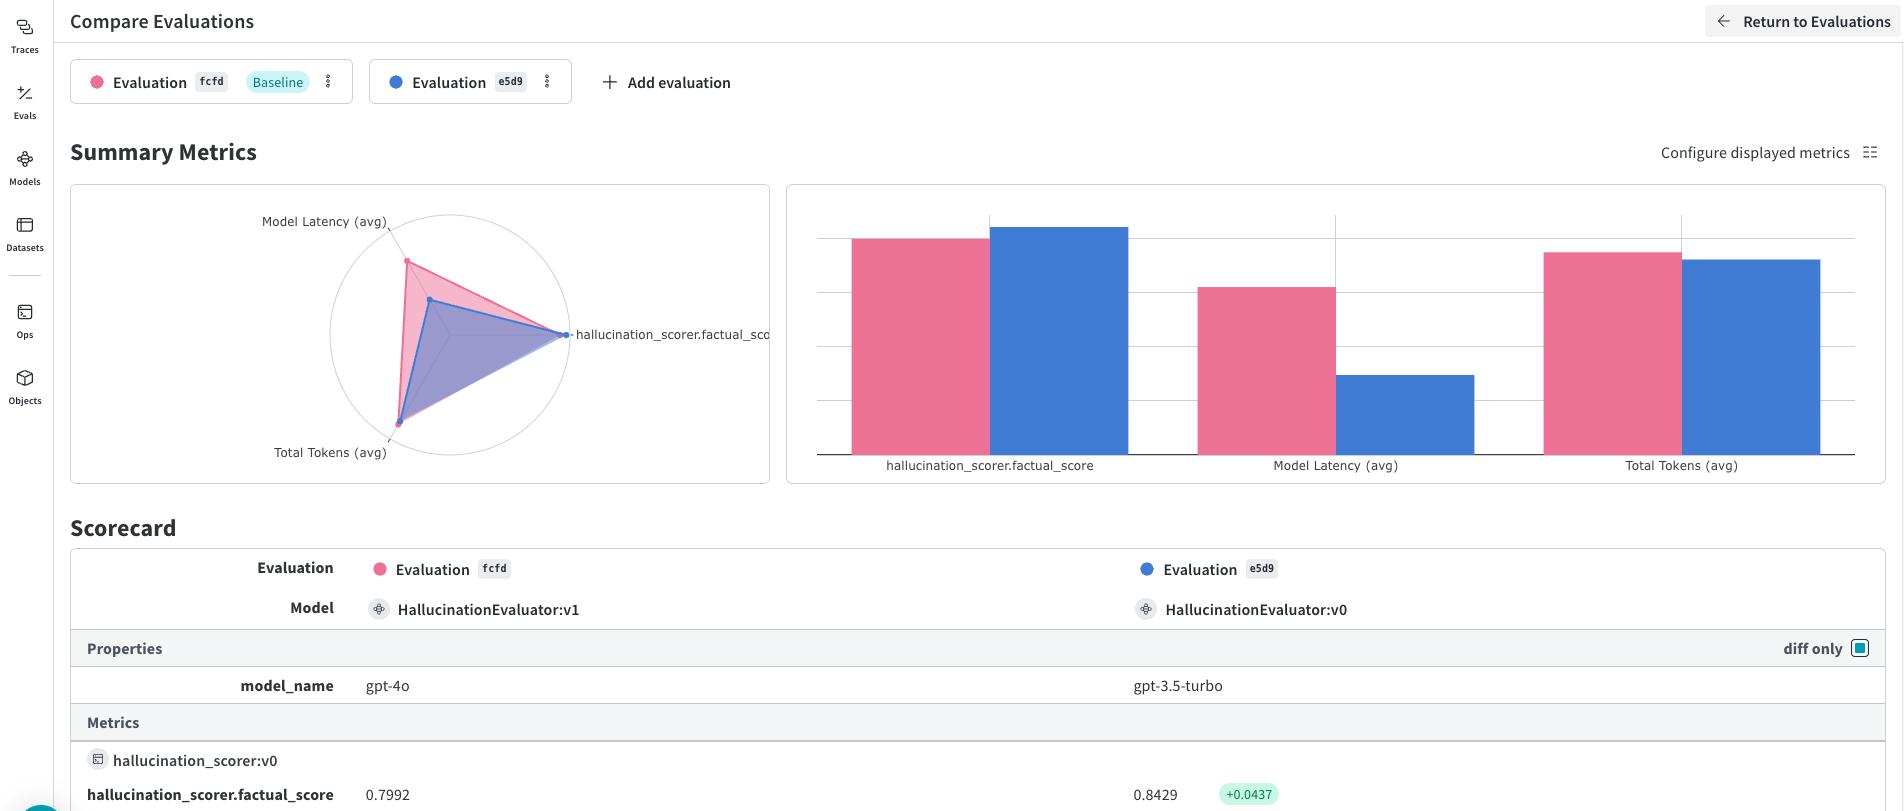

Note on GPT-4o vs. GPT-3.5 Hallucination Patterns in RAG Applications:

During the evaluation for this particular usecase, it was observed that GPT-4o tends to produce more hallucinations than GPT-3.5, which may seem unexpected at first. However, this difference can be explained by how hallucinations manifest in Retrieval-Augmented Generation (RAG).

A common type of hallucination in RAG is factual but ungrounded. For example, given the premise "The capital of France is Berlin," a generated response stating "The capital of France is Paris" would be considered a hallucination—even though it is factually correct—because the generated statement is not derived from the provided retrieval context.

This issue arises when the model generates answers that are based on its pre-trained knowledge rather than the specific textual data retrieved as part of the RAG process.

GPT-4o, with its tendency to produce more detailed and precise responses, sometimes is more prone to this type of hallucination. As its answers are often longer and more comprehensive, they contain remote facts or statements that may not align with or be verifiable from the retrieved context. As a result, the evaluation score for GPT-4 may appear lower, even though some of the hallucinated statements might still be factually accurate.


## 🚀 Run Hallucination Evaluation Using Predefined Scorer

Running for one question example:

In [ ]:
# Initialize clients and scorers
llm_client = OpenAI()
hallucination_scorer = HallucinationFreeScorer(
    client=llm_client,
    model_id="gpt-4o",
    column_map={"context": "input", "output": "other_col"}
)

@weave.op
def rag_response(input: str) -> str:
  rag= HallucinationEvaluator()
  response = rag.predict(input)
  return response['answer']


rag= HallucinationEvaluator()
question = "Why fine-tuning GPT-4 is more challenging than GPT-3.5"
response = rag.predict(question)

dataset = [
    {"input": response['context']},
]

# Run evaluation
evaluation = weave.Evaluation(
    dataset=dataset,
    scorers=[hallucination_scorer],
)
result = asyncio.run(evaluation.evaluate(rag_response))
print(result)

## 📌 Conclusion

**Evaluation of Faithfulness**:

In this notebook, we focused on evaluating the **Hallucination Score** of answers generated by our
Retrieval-Augmented Generation (RAG) system using custom scorer ( open source model) and also predefined scorer. By breaking down the answers into simpler
statements and checking each one against the retrieved context, we quantified how much we can
**trust** the responses provided by the system.

 **How Weave Helps**:

 Weave played a crucial role in this process by:

 - **Tracking**: Weave's `@weave.op()` decorators allowed us to track the inputs and outputs of our
   functions seamlessly. This provided transparency into each step of our pipeline.
 - **Evaluation**: Using Weave's `Evaluation` class, we conducted structured evaluations and stored
   the results in the **'eval'** section. This made it easy to analyze and compare results.
 - **Reproducibility**: By defining our prompts and models as Weave Objects and Models, we ensured
   that our pipeline is reproducible and easily shareable.

 **Benefits of Weave Integration**:

 - **Enhanced Trust**: By integrating faithfulness evaluation, we added an extra layer of **trust** to
   our system. Users can be more confident in the accuracy of the responses.
 - **Debugging and Improvement**: Weave's tracking capabilities make it easier to identify areas
  where the model may not be performing as expected, facilitating targeted improvements.
- **Comprehensive Insights**: The ability to store and analyze evaluation results within Weave
   provides comprehensive insights into model performance over time.

 ---

 ## 🔚 Final Thoughts

 By integrating **Weave** into our code, we've enhanced the transparency, reliability, and
 **trustworthiness** of our RAG system. We can:

 - Track function inputs and outputs.
 - Reuse prompt templates as Weave Objects.
 - Perform comprehensive evaluations focused on faithfulness.
 - Define an end-to-end pipeline as a Weave Model for easier evaluation.
 - Store evaluation results in the **'eval'** section of Weave for better analysis.

 This approach not only provides valuable insights into the trustworthiness of the generated
 answers but also contributes to building systems that users can rely on with confidence.

